# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
loglik = tf.log(input_y*(input_y - probability) 
                + (1-input_y) * (input_y + probability))
loss = -tf.reduce_mean(loglik * advantages)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5]) # do not need this
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    reward = r.copy()
    for i in reversed(range(0,len(r)-1)):
        reward[i] += gamma * reward[i+1]
    return reward
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    # get latest observation x from xs[-1]
    myPredict = sess.run([predicted_state], feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [10]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) # array of observation
        y = 1 if action == 0 else 0 # flipping action
        ys.append(y) # array of flipped actions
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                # flip y from ys to get back action
                actions = np.array([(1-y) for y in epy[:-1]])
                pState, loss, _ = sess.run(fetches=[predicted_state, model_loss, updateModel]
                        , feed_dict={previous_state:np.hstack([epx[0:-1,:], actions]),
                                     true_observation:epx[1:,:],
                                     true_reward:epr[1:,:],
                                     true_done:epd[1:,:]})
                state_nextsAll = np.hstack([epx[1:,:], epr[1:,:], epd[1:,:]])
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                discounted_reward = discount_rewards(epr)
                discounted_reward -= np.mean(discounted_reward)
                discounted_reward /= np.std(discounted_reward)
                tGrad = sess.run(fetches=newGrads
                        , feed_dict={input_y:epy,
                                     advantages:discounted_reward,
                                     observations:epx})
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients become too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    sess.run(fetches=updateGrads
                             , feed_dict={W1Grad:gradBuffer[0], W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %d. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4. Reward 10.333333. action: 1.000000. mean reward 10.333333.
World Perf: Episode 7. Reward 17.333333. action: 1.000000. mean reward 10.403333.
World Perf: Episode 10. Reward 31.333333. action: 1.000000. mean reward 10.612633.
World Perf: Episode 13. Reward 25.000000. action: 1.000000. mean reward 10.756507.
World Perf: Episode 16. Reward 33.333333. action: 0.000000. mean reward 10.982275.
World Perf: Episode 19. Reward 29.000000. action: 1.000000. mean reward 11.162453.
World Perf: Episode 22. Reward 13.666667. action: 1.000000. mean reward 11.187495.
World Perf: Episode 25. Reward 16.666667. action: 0.000000. mean reward 11.242286.
World Perf: Episode 28. Reward 16.000000. action: 1.000000. mean reward 11.289864.
World Perf: Episode 31. Reward 22.666667. action: 0.000000. mean reward 11.403632.
World Perf: Episode 34. Reward 16.333333. action: 0.000000. mean reward 11.452929.
World Perf: Episode 37. Reward 16.333333. action: 0.000000. mean reward 11.501733.
World 

World Perf: Episode 304. Reward 19.333333. action: 0.000000. mean reward 24.277100.
World Perf: Episode 307. Reward 31.333333. action: 1.000000. mean reward 24.291275.
World Perf: Episode 310. Reward 29.000000. action: 1.000000. mean reward 24.195284.
World Perf: Episode 313. Reward 27.333333. action: 0.000000. mean reward 24.171648.
World Perf: Episode 316. Reward 54.000000. action: 1.000000. mean reward 24.788664.
World Perf: Episode 319. Reward 37.000000. action: 0.000000. mean reward 24.780020.
World Perf: Episode 322. Reward 31.000000. action: 0.000000. mean reward 24.961206.
World Perf: Episode 325. Reward 26.333333. action: 1.000000. mean reward 24.902809.
World Perf: Episode 328. Reward 34.666667. action: 0.000000. mean reward 31.113874.
World Perf: Episode 331. Reward 24.333333. action: 1.000000. mean reward 33.973835.
World Perf: Episode 334. Reward 18.666667. action: 0.000000. mean reward 33.553371.
World Perf: Episode 337. Reward 46.666667. action: 0.000000. mean reward 33.

World Perf: Episode 601. Reward 29.000000. action: 0.000000. mean reward 57.546482.
World Perf: Episode 604. Reward 57.333333. action: 0.000000. mean reward 59.096390.
World Perf: Episode 607. Reward 46.000000. action: 1.000000. mean reward 61.344177.
World Perf: Episode 610. Reward 45.000000. action: 1.000000. mean reward 62.812790.
World Perf: Episode 613. Reward 56.000000. action: 1.000000. mean reward 62.227661.
World Perf: Episode 616. Reward 38.333333. action: 0.000000. mean reward 61.520702.
World Perf: Episode 619. Reward 43.000000. action: 0.000000. mean reward 60.971172.
World Perf: Episode 622. Reward 67.666667. action: 0.000000. mean reward 60.609982.
World Perf: Episode 625. Reward 32.666667. action: 1.000000. mean reward 59.898907.
World Perf: Episode 628. Reward 79.000000. action: 1.000000. mean reward 59.826214.
World Perf: Episode 631. Reward 47.000000. action: 1.000000. mean reward 60.005535.
World Perf: Episode 634. Reward 32.000000. action: 0.000000. mean reward 59.

World Perf: Episode 898. Reward 52.000000. action: 0.000000. mean reward 55.402264.
World Perf: Episode 901. Reward 62.000000. action: 1.000000. mean reward 55.588531.
World Perf: Episode 904. Reward 88.666667. action: 0.000000. mean reward 55.543884.
World Perf: Episode 907. Reward 33.000000. action: 0.000000. mean reward 55.142975.
World Perf: Episode 910. Reward 73.000000. action: 0.000000. mean reward 54.906765.
World Perf: Episode 913. Reward 57.333333. action: 0.000000. mean reward 54.588741.
World Perf: Episode 916. Reward 71.666667. action: 1.000000. mean reward 55.544147.
World Perf: Episode 919. Reward 58.666667. action: 0.000000. mean reward 56.947750.
World Perf: Episode 922. Reward 48.000000. action: 0.000000. mean reward 56.378956.
World Perf: Episode 925. Reward 64.666667. action: 0.000000. mean reward 58.915821.
World Perf: Episode 928. Reward 79.000000. action: 0.000000. mean reward 59.824795.
World Perf: Episode 931. Reward 75.000000. action: 1.000000. mean reward 59.

World Perf: Episode 1189. Reward 131.333333. action: 0.000000. mean reward 103.089806.
World Perf: Episode 1192. Reward 143.333333. action: 1.000000. mean reward 105.516624.
World Perf: Episode 1195. Reward 113.666667. action: 0.000000. mean reward 105.546700.
World Perf: Episode 1198. Reward 68.666667. action: 0.000000. mean reward 105.674660.
World Perf: Episode 1201. Reward 59.666667. action: 0.000000. mean reward 105.781685.
World Perf: Episode 1204. Reward 116.000000. action: 0.000000. mean reward 107.979851.
World Perf: Episode 1207. Reward 111.000000. action: 0.000000. mean reward 108.535126.
World Perf: Episode 1210. Reward 95.333333. action: 0.000000. mean reward 107.682159.
World Perf: Episode 1213. Reward 88.333333. action: 0.000000. mean reward 107.203247.
World Perf: Episode 1216. Reward 152.333333. action: 0.000000. mean reward 107.048027.
World Perf: Episode 1219. Reward 94.000000. action: 0.000000. mean reward 109.105804.
World Perf: Episode 1222. Reward 53.333333. acti

World Perf: Episode 1474. Reward 141.333333. action: 0.000000. mean reward 158.986496.
World Perf: Episode 1477. Reward 73.333333. action: 0.000000. mean reward 157.650467.
World Perf: Episode 1480. Reward 172.333333. action: 0.000000. mean reward 156.977875.
World Perf: Episode 1483. Reward 141.000000. action: 0.000000. mean reward 158.278564.
World Perf: Episode 1486. Reward 104.000000. action: 0.000000. mean reward 156.925888.
World Perf: Episode 1489. Reward 130.333333. action: 1.000000. mean reward 155.671982.
World Perf: Episode 1492. Reward 200.000000. action: 0.000000. mean reward 155.247864.
World Perf: Episode 1495. Reward 77.666667. action: 0.000000. mean reward 155.078598.
World Perf: Episode 1498. Reward 125.333333. action: 0.000000. mean reward 154.593811.
World Perf: Episode 1501. Reward 129.000000. action: 0.000000. mean reward 154.124832.
World Perf: Episode 1504. Reward 112.333333. action: 0.000000. mean reward 155.215759.
World Perf: Episode 1507. Reward 178.333333. 

World Perf: Episode 1759. Reward 178.000000. action: 1.000000. mean reward 170.204102.
World Perf: Episode 1762. Reward 166.000000. action: 1.000000. mean reward 171.426697.
World Perf: Episode 1765. Reward 176.333333. action: 1.000000. mean reward 171.037170.
World Perf: Episode 1768. Reward 145.000000. action: 0.000000. mean reward 172.038986.
World Perf: Episode 1771. Reward 169.333333. action: 0.000000. mean reward 170.888016.
World Perf: Episode 1774. Reward 200.000000. action: 0.000000. mean reward 172.431198.
World Perf: Episode 1777. Reward 162.333333. action: 0.000000. mean reward 173.570511.
World Perf: Episode 1780. Reward 200.000000. action: 0.000000. mean reward 175.118515.
World Perf: Episode 1783. Reward 138.000000. action: 1.000000. mean reward 175.974976.
World Perf: Episode 1786. Reward 168.000000. action: 0.000000. mean reward 177.132645.
World Perf: Episode 1789. Reward 173.333333. action: 0.000000. mean reward 177.264481.
World Perf: Episode 1792. Reward 154.000000

World Perf: Episode 2044. Reward 191.333333. action: 0.000000. mean reward 194.617996.
World Perf: Episode 2047. Reward 200.000000. action: 0.000000. mean reward 195.702515.
World Perf: Episode 2050. Reward 200.000000. action: 0.000000. mean reward 196.689468.
World Perf: Episode 2053. Reward 193.666667. action: 1.000000. mean reward 197.803787.
World Perf: Episode 2056. Reward 186.000000. action: 1.000000. mean reward 198.832718.
World Perf: Episode 2059. Reward 200.000000. action: 1.000000. mean reward 197.016846.
World Perf: Episode 2062. Reward 193.000000. action: 0.000000. mean reward 198.072937.
World Perf: Episode 2065. Reward 200.000000. action: 0.000000. mean reward 199.306778.
World Perf: Episode 2068. Reward 200.000000. action: 1.000000. mean reward 197.460068.
World Perf: Episode 2071. Reward 200.000000. action: 1.000000. mean reward 198.475418.
World Perf: Episode 2074. Reward 200.000000. action: 1.000000. mean reward 199.524353.
World Perf: Episode 2077. Reward 200.000000

World Perf: Episode 2329. Reward 198.666667. action: 1.000000. mean reward 228.600449.
World Perf: Episode 2332. Reward 194.333333. action: 1.000000. mean reward 228.966110.
World Perf: Episode 2335. Reward 200.000000. action: 1.000000. mean reward 228.664566.
World Perf: Episode 2338. Reward 200.000000. action: 0.000000. mean reward 229.104111.
World Perf: Episode 2341. Reward 178.000000. action: 1.000000. mean reward 229.510132.
World Perf: Episode 2344. Reward 199.666667. action: 0.000000. mean reward 229.933121.
World Perf: Episode 2347. Reward 192.000000. action: 0.000000. mean reward 230.267960.
World Perf: Episode 2350. Reward 200.000000. action: 1.000000. mean reward 230.700989.
World Perf: Episode 2353. Reward 200.000000. action: 0.000000. mean reward 231.064926.
World Perf: Episode 2356. Reward 193.666667. action: 1.000000. mean reward 231.411942.
World Perf: Episode 2359. Reward 196.666667. action: 0.000000. mean reward 229.535461.
World Perf: Episode 2362. Reward 200.000000

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/anaconda3/envs/urop/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


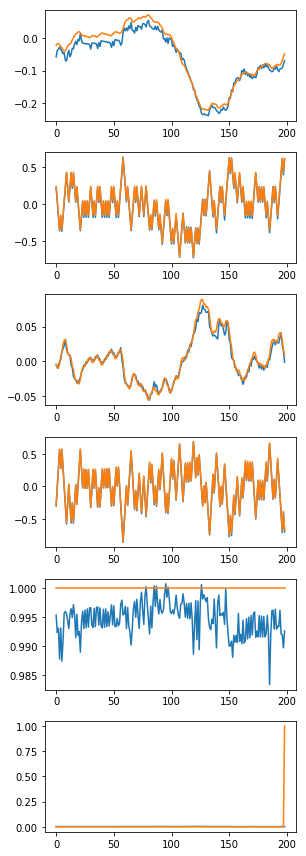

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])   # draw the model predictions
    plt.subplot(6,2,2*i+1)
    
    ################################################################################
    # TODO: draw the real environment for comparison                               #
    ################################################################################
    plt.plot(state_nextsAll[:,i])
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
plt.tight_layout()